# Assignment 08
#### Collaborators: Mauricio Bermudez, Alvaro Montoya Ruiz, Hriday Reddy Purma
#### Task: Exploring Generative Models - GANs vs. Diffusion with Hugging Face Diffusers

# 1) Introduction


/////////introduction setting the context, clear learning objectives, and a brief background refresher.

Generative models have revolutionized many areas of machine learning, particularly in computer vision and natural language processing. Two prominent families of generative models are Generative Adversarial Networks (GANs) and, more recently, Denoising Diffusion Probabilistic Models (Diffusion Models). While GANs have been dominant for several years, diffusion models have shown remarkable success, often producing state-of-the-art results in image generation tasks.

This assignment aims to provide hands-on experience with diffusion models using the popular Hugging Face diffusers library. You will explore different pre-trained diffusion models and their components, compare their outputs, and reflect on their characteristics compared to GANs.


# 2) Methodology / Tasks


### Importing Libraries and Setting the Device

We begin by importing libraries for numerical computations, plotting, neural network modeling with PyTorch, evaluation metrics, and wandb for experiment tracking. We then set the device based on CUDA availability.

In [2]:
import torch
from diffusers import (
    StableDiffusionPipeline,
    DDIMScheduler,
    PNDMScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler
)
from PIL import Image
import matplotlib.pyplot as plt
import random
import wandb
# pip install torch diffusers transformers accelerate safetensors pillow matplotlib
seed = 42
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.   

### Setup of hyperparameters and configuration


In [6]:

prompts = [
    "dragon breathing flames, pixel art style, highly detailed, fire particles, glowing eyes, cinematic lighting, 16-bit color palette",
    "cyberpunk city skyline, pixel art style, neon lights, retro futuristic, dusk, reflections on water, moody atmosphere, vaporwave aesthetic",
    "medieval warrior in battle stance, pixel art style, full armor, sword glowing with runes, stormy sky, epic pose, dynamic lighting, SNES-era RPG feel"
]

seeds = [42, 123, 999]
num_inference_steps = 30
guidance_scale = 7.5
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

num_inference_steps_2 = 40
guidance_scale_2 = 10
# -------------------------------
# Models and Schedulers
# -------------------------------

#https://civitai.com/models/129879/dreamshaper-pixelart
#https://civitai.com/models/130106/stylizedpixel
#https://civitai.com/models/85953/pixelstyleckpt


# Please change the directory for loading the models
model_ids = {
    "Dream_shaper": r"C:\Developer\Visual Studio Code\Python\Deep-Learning-Assignments\Assignment 08\pixel art models\dreamshaperPixelart_v10.safetensors",
    "Stylizedpixel": r"C:\Developer\Visual Studio Code\Python\Deep-Learning-Assignments\Assignment 08\pixel art models\stylizedpixel_m80.safetensors",
    "pixelStyle": r"C:\Developer\Visual Studio Code\Python\Deep-Learning-Assignments\Assignment 08\pixel art models\pixelstyleckpt_strength07.safetensors"
}

schedulers = {
    "PNDM": PNDMScheduler,
    "DDIM": DDIMScheduler,
    "EulerA": EulerAncestralDiscreteScheduler,
    "DPM Solver": DPMSolverMultistepScheduler
}

# Read API Key and login
with open('../API_KEY.txt', 'r') as file:  # One level up
    wandb_api_key = file.read().strip()

if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("WANDB_API_KEY not found in API_KEY.txt!")

# Initialize WandB
wandb.init(
    project="Assignment8",
    entity="usf-magma",
    config={
        "prompts": prompts,
        "seeds": seeds,
        "num_inference_steps": num_inference_steps,
        "guidance_scale": guidance_scale,
        "device": device,
        "model_ids": list(model_ids.keys()),
        "schedulers": list(schedulers.keys())
    }
)

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maurb\_netrc
wandb: Currently logged in as: bermudezm (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Utility Functions

In [7]:
def is_safetensors_model(path):
    return path.lower().endswith(".safetensors")

In [8]:
def load_pipeline(model_id, scheduler_class=None):
    """Loads and returns a Stable Diffusion pipeline with optional scheduler replacement."""
    try:
        if is_safetensors_model(model_id):
            pipe = StableDiffusionPipeline.from_single_file(model_id, torch_dtype=torch.float16)
        else:
            pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
        
        pipe.to(device)

        if scheduler_class:
            pipe.scheduler = scheduler_class.from_config(pipe.scheduler.config)

        return pipe
    except Exception as e:
        print(f" Error loading model ({model_id}): {e}")
        return None

In [9]:
@torch.inference_mode()
def generate_image(pipe, prompt, seed, num_inference_steps, guidance_scale):
    try:
        generator = torch.Generator(device=config.device).manual_seed(seed)
        return pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]
    except Exception as e:
        print(f"Generation failed: {e}")
        return Image.new("RGB", (512, 512), color="gray")

In [10]:
def cleanup_pipe(pipe):
    """Safely deletes the pipeline to free GPU memory."""
    pipe.to("cpu")
    del pipe
    torch.cuda.empty_cache()

In [11]:
def display_model_grid(model_images, model_names, prompt_titles):
    """Displays a grid of images for each model."""
    num_models = len(model_names)
    num_prompts = len(prompt_titles)

    fig, axs = plt.subplots(num_prompts, num_models, figsize=(5 * num_models, 5))

    for m_idx, images in enumerate(model_images):
        for p_idx, img in enumerate(images):
            axs[p_idx, m_idx].imshow(img)
            axs[p_idx, m_idx].axis('off')
            if p_idx == 0:
                axs[p_idx, m_idx].set_title(model_names[m_idx], fontsize=10)
            if m_idx == 0:
                axs[p_idx, m_idx].set_ylabel(prompt_titles[p_idx], fontsize=10)

    plt.tight_layout()
    plt.show()

In [12]:
def display_scheduler_comparison_grid(all_results, model_names, scheduler_names, prompt_titles):
    """Displays a comparison grid of images generated with different schedulers."""
    num_models = len(model_names)
    num_schedulers = len(scheduler_names)
    num_prompts = len(prompt_titles)

    fig, axs = plt.subplots(num_prompts, num_schedulers * num_models, figsize=(5 * num_models, 5))

    for m_idx, model_result in enumerate(all_results):
        for s_idx, scheduler_result in enumerate(model_result):
            for p_idx, img in enumerate(scheduler_result):
                col = m_idx * num_schedulers + s_idx
                axs[p_idx, col].imshow(img)
                axs[p_idx, col].axis('off')
                if p_idx == 0:
                    axs[p_idx, col].set_title(f"{model_names[m_idx]}\n{scheduler_names[s_idx]}", fontsize=10)
                if col == 0:
                    axs[p_idx, col].set_ylabel(prompt_titles[p_idx], fontsize=10)

    plt.tight_layout()
    plt.show()

## 2.1) Basic Pipeline

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

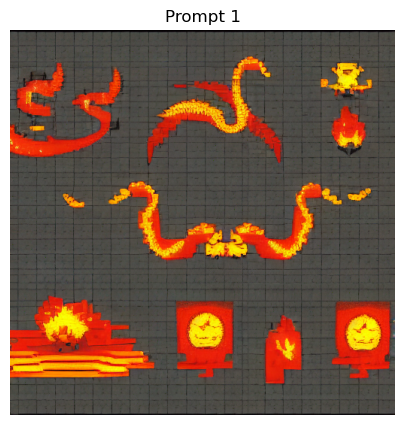

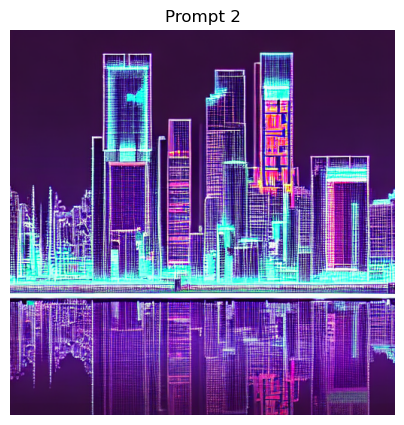

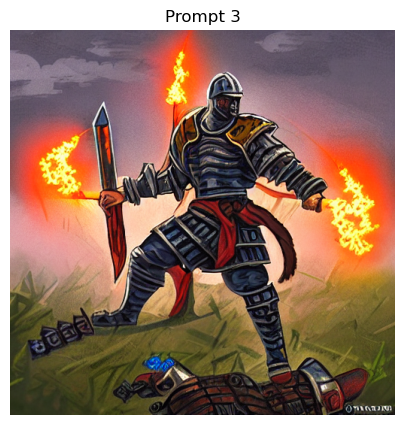

In [13]:
# Load pipeline
pipe_standard = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16 if device == "cuda" else torch.float32)
pipe_standard = pipe_standard.to(device)

# Generate and display images
images_standard = []
for prompt, seed in zip(prompts, seeds):
    generator = torch.Generator(device).manual_seed(seed)
    image_standard = pipe_standard(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator).images[0]
    images_standard.append(image_standard)

# Display images
for idx, img in enumerate(images_standard):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prompt {idx+1}")
plt.show()

## 2.2) Comparing different Duffusion Models/Checkpoints


Generating base images for model: Dream_shaper


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du


Generating base images for model: Stylizedpixel


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du


Generating base images for model: pixelStyle


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

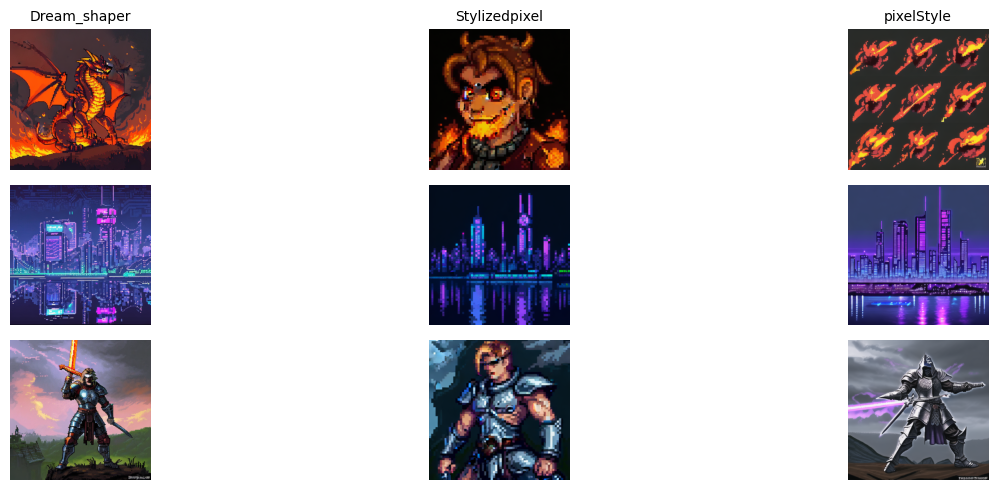

In [14]:
model_images = []

for model_name, model_path in model_ids.items():
    print(f"\nGenerating base images for model: {model_name}")
    pipe = load_pipeline(model_path)

    if pipe:
        images = [
            generate_image(pipe, prompt, seed, config.num_inference_steps, config.guidance_scale)
            for prompt, seed in zip(config.prompts, config.seeds)
        ]
        cleanup_pipe(pipe)
    else:
        images = [Image.new("RGB", (512, 512), color="gray") for _ in config.prompts]

    for i, (img, prompt, seed) in enumerate(zip(images, config.prompts, config.seeds)):
        wandb.log({
            f"Base/{model_name}/Prompt {i+1}": wandb.Image(
                img,
                caption=f"Prompt: {prompt} | Seed: {seed} | Steps: {config.num_inference_steps} | Guidance: {config.guidance_scale}"
            )
        })

    model_images.append(images)
# Display all generated images in a grid
display_model_grid(model_images, list(model_ids.keys()), config.prompts)

## 2.3) Exploring Schedulers


Evaluating model: Dream_shaper


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Testing with PNDM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DDIM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with EulerA scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DPM Solver scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du


Evaluating model: Stylizedpixel


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Testing with PNDM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DDIM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with EulerA scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DPM Solver scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du


Evaluating model: pixelStyle


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Testing with PNDM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DDIM scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with EulerA scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Testing with DPM Solver scheduler


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

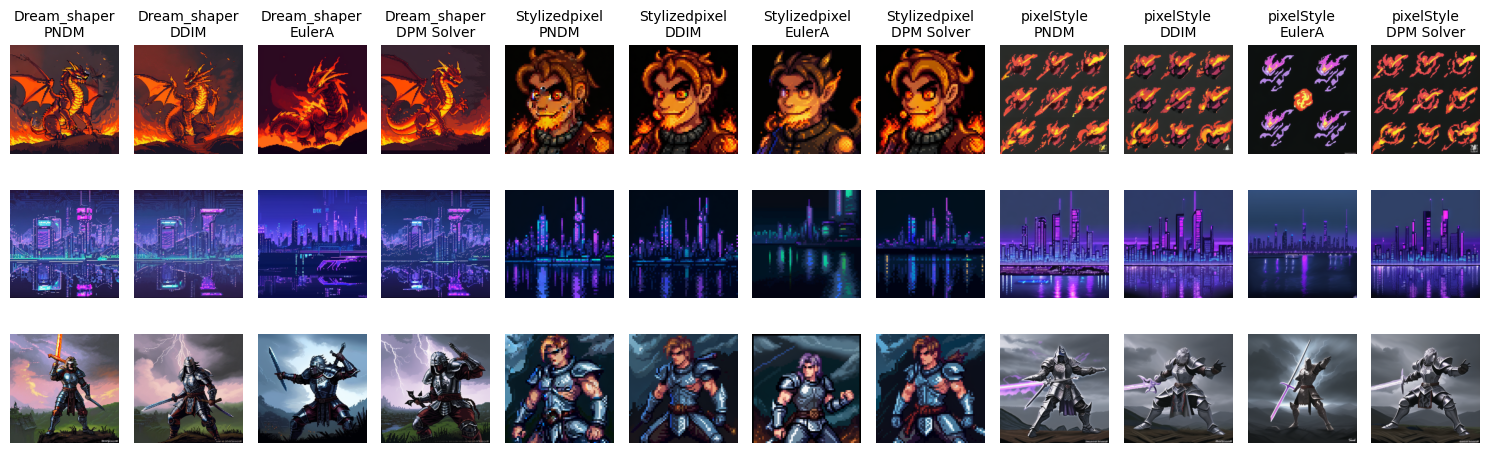

In [15]:

all_model_results = []

for model_name, model_path in model_ids.items():
    model_scheduler_results = []
    print(f"\nEvaluating model: {model_name}")

    base_pipe = load_pipeline(model_path)
    if not base_pipe:
        all_model_results.append([[Image.new("RGB", (512, 512), color="red") for _ in config.prompts]] * len(schedulers))
        continue

    for sched_name, sched_class in schedulers.items():
        print(f"Testing with {sched_name} scheduler")
        try:
            pipe = base_pipe
            pipe.scheduler = sched_class.from_config(pipe.scheduler.config)

            images = [
                generate_image(pipe, prompt, seed, config.num_inference_steps, config.guidance_scale)
                for prompt, seed in zip(config.prompts, config.seeds)
            ]

            for i, (img, prompt, seed) in enumerate(zip(images, config.prompts, config.seeds)):
                wandb.log({
                    f"Scheduled/{model_name}/{sched_name}/Prompt {i+1}": wandb.Image(
                        img,
                        caption=f"{sched_name} | Prompt: {prompt} | Seed: {seed} | Steps: {config.num_inference_steps} | Guidance: {config.guidance_scale}"
                    )
                })

            model_scheduler_results.append(images)
        except Exception as e:
            print(f"Failed with {sched_name}: {e}")
            model_scheduler_results.append([Image.new("RGB", (512, 512), color="red") for _ in config.prompts])

    cleanup_pipe(base_pipe)
    all_model_results.append(model_scheduler_results)

# Display Results
display_scheduler_comparison_grid(
    all_model_results,
    list(model_ids.keys()),
    list(schedulers.keys()),
    [f"Prompt {i+1}" for i in range(len(prompts))]
)


## 2.4) Parameter Tuning

In [16]:
results = []
# Choose one model and scheduler
chosen_model_name = "Dream_shaper"
chosen_scheduler_name = "EulerA"

model_path = model_ids[chosen_model_name]
scheduler_class = schedulers[chosen_scheduler_name]

# Hyperparameter values to explore
step_values = [15, 50, 100]
guidance_values = [1.0, 7.5, 15.0]

# Load pipeline
pipe = load_pipeline(model_path, scheduler_class)
if pipe is None:
    raise RuntimeError("Pipeline failed to load for chosen model/scheduler.")

# Run experiments
for step in step_values:
    for guidance in guidance_values:
        row_results = []
        print(f"\nRunning: steps={step}, guidance={guidance}")

        for i, (prompt, seed) in enumerate(zip(config.prompts, config.seeds)):
            img = generate_image(pipe, prompt, seed, step, guidance)

            # Log to wandb
            wandb.log({
                f"Exploration/{chosen_model_name}/{chosen_scheduler_name}/Prompt {i+1}/steps={step}_guidance={guidance}": wandb.Image(
                    img,
                    caption=f"Prompt: {prompt}\nSeed: {seed}\nSteps: {step}\nGuidance: {guidance}"
                ),
                "prompt_index": i,
                "steps": step,
                "guidance": guidance,
                "model": chosen_model_name,
                "scheduler": chosen_scheduler_name
            })

            # Collect for display
            row_results.append((img, prompt, seed, step, guidance))

        results.append(row_results)

cleanup_pipe(pipe)
wandb.finish()

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .



Running: steps=15, guidance=1.0


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


Running: steps=15, guidance=7.5


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


Running: steps=15, guidance=15.0


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


Running: steps=50, guidance=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Running: steps=50, guidance=7.5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Running: steps=50, guidance=15.0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Running: steps=100, guidance=1.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Running: steps=100, guidance=7.5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Running: steps=100, guidance=15.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

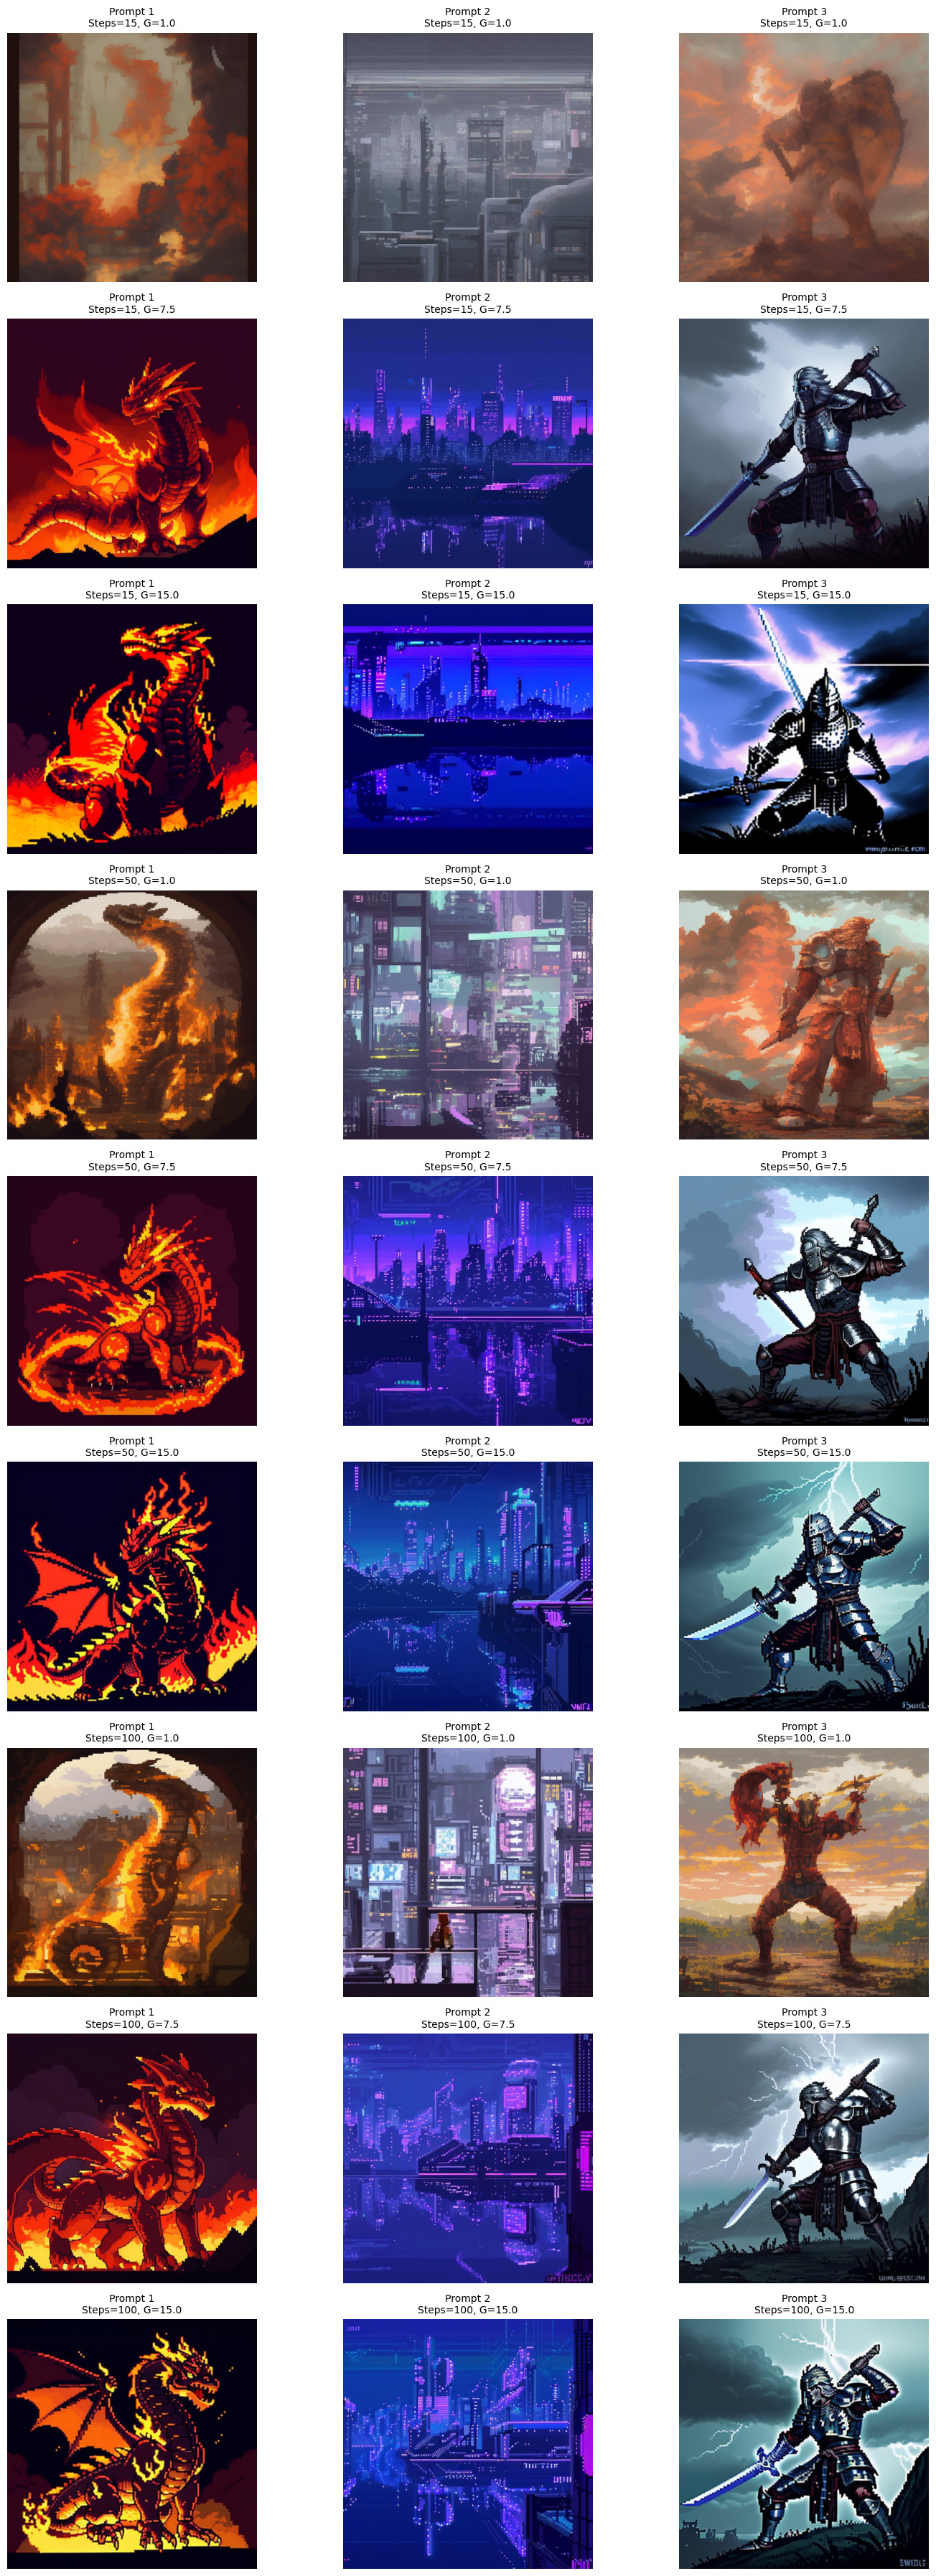

In [17]:
# Display all results
def show_result_grid(results, prompts, step_values, guidance_values):
    num_prompts = len(prompts)
    num_rows = len(step_values) * len(guidance_values)

    fig, axs = plt.subplots(num_rows, num_prompts, figsize=(5 * num_prompts, 4 * num_rows))

    for idx, row in enumerate(results):
        for p_idx, (img, prompt, seed, step, guidance) in enumerate(row):
            ax = axs[idx, p_idx] if num_rows > 1 else axs[p_idx]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Prompt {p_idx+1}\nSteps={step}, G={guidance}", fontsize=10)

    plt.tight_layout()
    plt.show()

show_result_grid(results, config.prompts, step_values, guidance_values)

## 2.5) Conceptual Comparison: Diffusion vs GANs

Based on your experiences in this assignment, class lectures, and potentially some light reading (reference any external sources used), write a section discussing the following:

Strengths and Weaknesses: Compare Diffusion Models and GANs regarding:
Training Stability
Sample Quality and Diversity
Mode Collapse (Is it less of an issue for diffusion?)
Computational Cost (Training vs. Inference)
Controllability / Editability (Which framework might be easier to adapt for tasks like image editing?)
diffusers Library: Briefly comment on your experience using the diffusers library. Was it easy to use? What are its advantages for exploring these models?

## 3.0) Results

#
#
#

## 3.0) Results


hi please make sure to write a part for the results of the models. Results might be using the fidelity of the model, which scheduler improved the quality better, which num of steps and guidance were better and so on.

## 4.0) Discussion 

Discussion part should talk about on maybe some challeneges, trades off between quality and creativity . Also in discussion we will have to talk about the same we did for section 2.5


## 5.0) Conclusion

Make final statements on the results and text analysis